## Введение

К нам обратился фермер, владелец молочного хозяйства «Вольный луг», который хочет купить бурёнок, чтобы расширить поголовье стада коров. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным. Для этого необходимо разработать модель машинного обучения, которая поможет принимать объективное решение о покупке.



## Загрузка данных

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, \
    precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal = ',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal = ',')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal = ',')

In [4]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [6]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [7]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [8]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [9]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Для дальнейшего удобства при работе с данными переименуем столбцы: запишем их на английском языке в одном регистре, без лишних знаков. 

In [10]:
ferma_main = ferma_main.rename(columns={
    'Удой, кг': 'udoi',
    'ЭКЕ (Энергетическая кормовая единица)': 'eke',
    'Сырой протеин, г': 'raw_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'spo',
    'Порода': 'race',
    'Тип пастбища': 'pastbish_type',
    'порода папы_быка': 'race_papa_byk',
    'Жирность,%': 'how_fat',
    'Белок,%': 'belok',
    'Вкус молока': 'milk_taste',
    'Возраст': 'age'
})
ferma_main.head()

,id,udoi,eke,raw_protein,spo,race,pastbish_type,race_papa_byk,how_fat,belok,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [11]:
ferma_dad = ferma_dad.rename(columns={
    'Имя Папы': 'papa_name'
})
ferma_dad.head()

,id,papa_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [12]:
cow_buy = cow_buy.rename(columns={
    'Имя_папы': 'papa_name',
    'Порода': 'race',
    'Тип пастбища': 'pastbish_type',
    'порода папы_быка': 'race_papa_byk',
    'Текущая_жирность,%': 'how_fat_now',
    'Текущий_уровень_белок,%': 'belok_now',
    'Возраст': 'age'
})
cow_buy.head()

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Названия стобцов приведены в более удобный вид. Пропусков в данных не обнаружилось, но тип данных в некоторых столбцах надо преобразовать в числовой, так как это подразумевает хранящееся значение. 

##  Предобработка данных

Преобразуем тип данных в числовой в таблицах ferma_main и cow_buy. 

In [14]:
df = ['eke', 'spo', 'how_fat', 'belok']
for i in df:
    ferma_main[i] = pd.to_numeric(ferma_main[i], errors='coerce')
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             634 non-null    int64  
 1   udoi           634 non-null    int64  
 2   eke            634 non-null    float64
 3   raw_protein    634 non-null    int64  
 4   spo            634 non-null    float64
 5   race           634 non-null    object 
 6   pastbish_type  634 non-null    object 
 7   race_papa_byk  634 non-null    object 
 8   how_fat        634 non-null    float64
 9   belok          634 non-null    float64
 10  milk_taste     634 non-null    object 
 11  age            634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [15]:
df = ['how_fat_now', 'belok_now']
for i in df:
    #cow_buy[i] = cow_buy[i].str.replace(',', '.')
    cow_buy[i] = pd.to_numeric(cow_buy[i], errors='coerce')
cow_buy.head()

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [16]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   race           20 non-null     object 
 1   pastbish_type  20 non-null     object 
 2   race_papa_byk  20 non-null     object 
 3   papa_name      20 non-null     object 
 4   how_fat_now    20 non-null     float64
 5   belok_now      20 non-null     float64
 6   age            20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Теперь проверим данные на наличие дубликатов. 

In [17]:
ferma_main.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
629     True
630     True
631     True
632     True
633     True
Length: 634, dtype: bool

In [18]:
ferma_main.tail()

,id,udoi,eke,raw_protein,spo,race,pastbish_type,race_papa_byk,how_fat,belok,milk_taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


Пять строк полностью одинаковы, надо оставить только одну из них, скорее всего это техническая ошибка. 

In [19]:
ferma_main = ferma_main.drop_duplicates(keep='first')
ferma_main.tail()

,id,udoi,eke,raw_protein,spo,race,pastbish_type,race_papa_byk,how_fat,belok,milk_taste,age
624,625,6812,15.4,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет
628,629,6503,16.2,2283,0.94,Вис Бик Айдиал,Холмистое,Соверин,3.71,3.076,вкусно,более_2_лет


В стобцах значения для разных строк могут повторяться, это нормально, но id должен быть уникальным, проверим его. 

In [20]:
ferma_main['id'].duplicated().sum()

0

Аналогично таблице ferma_main обратоаем дубликаты и в других таблицах. 

In [21]:
cow_buy.duplicated().sum()

4

In [22]:
ferma_dad = ferma_dad.drop_duplicates(keep='first')
ferma_dad.duplicated().sum()

0

In [23]:
ferma_dad['id'].duplicated().sum()

0

Также, стоит проверить неявные дубликаты в категориальных значениях. 

In [24]:
df = ['race', 'pastbish_type', 'race_papa_byk', 'milk_taste', 'age']
for i in df:
    print(ferma_main[i].value_counts())

Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: race, dtype: int64
Холмистое    351
Равнинное    253
Равнинные     25
Name: pastbish_type, dtype: int64
Соверин    311
Айдиал     240
Айдиалл     78
Name: race_papa_byk, dtype: int64
вкусно       371
не вкусно    258
Name: milk_taste, dtype: int64
более_2_лет    519
менее_2_лет    110
Name: age, dtype: int64


В типе пастбища и породе папы быка есть неявные дубликаты: Равнинное и Равнинные, Айдиал и Айдиалл. Избавимся от них, приведем к одному названию

In [25]:
ferma_main['pastbish_type'] = ferma_main['pastbish_type'].replace('Равнинные', 'Равнинное')
ferma_main['race_papa_byk'] = ferma_main['race_papa_byk'].replace('Айдиалл', 'Айдиал')
df = ['pastbish_type', 'race_papa_byk']
for i in df:
    print(ferma_main[i].value_counts())

Холмистое    351
Равнинное    278
Name: pastbish_type, dtype: int64
Айдиал     318
Соверин    311
Name: race_papa_byk, dtype: int64


In [26]:
df = ['race', 'pastbish_type', 'race_papa_byk', 'papa_name', 'age']
for i in df:
    print(cow_buy[i].value_counts())

РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: race, dtype: int64
равнинное    11
холмистое     9
Name: pastbish_type, dtype: int64
Соверин    12
Айдиал      8
Name: race_papa_byk, dtype: int64
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: papa_name, dtype: int64
более_2_лет    15
менее_2_лет     5
Name: age, dtype: int64


In [27]:
ferma_dad['papa_name'].value_counts()

Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: papa_name, dtype: int64

Здесь все нормально, неявных дубликатов не выявлено. 

Итак, данные подготовлены. Изменен тип данных в некоторых столбцах на числовой, дубликаты обработаны. Можно приступать к анализу. 

## Исследовательский анализ данных

Сначала изучим общую характеристику для количественных признаков

In [28]:
ferma_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
udoi,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
eke,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
raw_protein,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
spo,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
how_fat,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
belok,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


Максимальный удой, равный 45616 кг выглядит довольно странным, возможно, это выброс. Рассмотрим колчиственные признаки по-отдельности. 

<b>Удой</b>

Text(0.5, 1.0, 'Ящик с усами для признака удой')

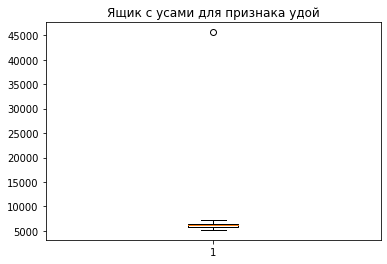

In [29]:
plt.boxplot(ferma_main['udoi'])
plt.title('Ящик с усами для признака удой')


(2000.0, 12000.0)

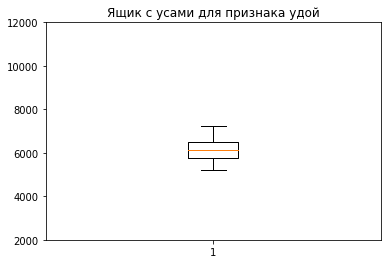

In [30]:
plt.boxplot(ferma_main['udoi'])
plt.title('Ящик с усами для признака удой')
plt.ylim(2000, 12000)


(5100.0, 7300.0)

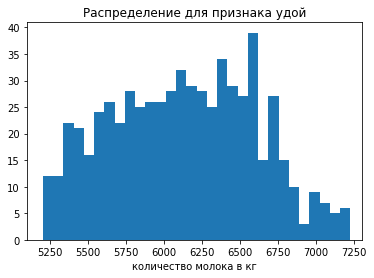

In [31]:
plt.hist(ferma_main['udoi'], bins=600)
plt.title('Распределение для признака удой')
plt.xlabel('количество молока в кг')
plt.xlim(5100, 7300)

Распределение выглядит близким к нормальному, как мы и думали, 45616 кг удоя является выбросом, избавимся от него. 

In [32]:
ferma_main = ferma_main.query('udoi != 45616')
ferma_main['udoi'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: udoi, dtype: float64

<b>eke (эке)</b>

Text(0.5, 1.0, 'Ящик с усами для признака ЭКЕ')

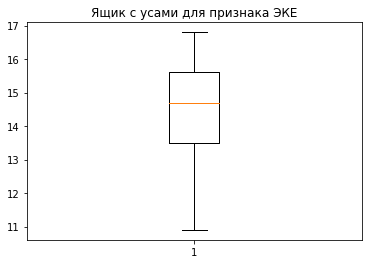

In [33]:
plt.boxplot(ferma_main['eke'])
plt.title('Ящик с усами для признака ЭКЕ')

Text(0.5, 0, 'показатель питательности корма коровы')

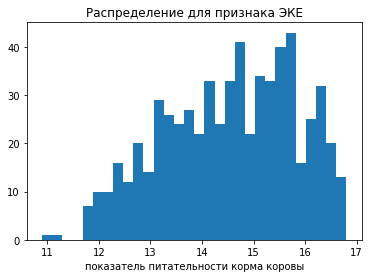

In [34]:
plt.hist(ferma_main['eke'], bins=30)
plt.title('Распределение для признака ЭКЕ')
plt.xlabel('показатель питательности корма коровы')

Распределение близко к нормальному, выбросы не обнаружены, оставим этот признак как есть. 

<b>raw_protein (Сырой протеин)</b>

Text(0.5, 1.0, 'Ящик с усами для признака raw_protein (Сырой протеин)')

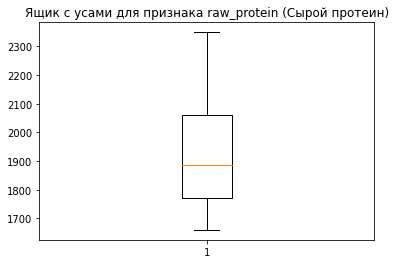

In [35]:
plt.boxplot(ferma_main['raw_protein'])
plt.title('Ящик с усами для признака raw_protein (Сырой протеин)')

Text(0.5, 0, 'количество сырого протеина в корме')

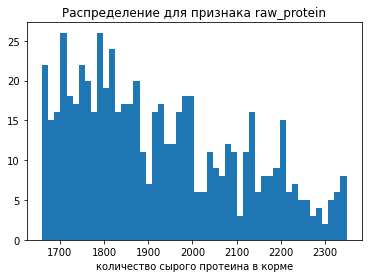

In [36]:
plt.hist(ferma_main['raw_protein'], bins=50) 
plt.title('Распределение для признака raw_protein')
plt.xlabel('количество сырого протеина в корме')

В основном количество сырого протеина приходится на диапазон 1700-1900, но выбросов и аномальных значений нет, оставляем без изменений. 

<b>spo(СПО (Сахаро-протеиновое соотношение))</b>

Text(0.5, 1.0, 'Ящик с усами для признака spo')

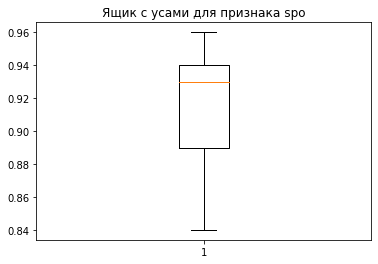

In [37]:
plt.boxplot(ferma_main['spo'])
plt.title('Ящик с усами для признака spo')

Text(0.5, 0, 'отношение сахара к протеину')

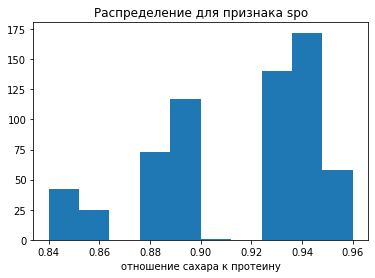

In [38]:
plt.hist(ferma_main['spo'], bins=10) 
plt.title('Распределение для признака spo')
plt.xlabel('отношение сахара к протеину')

Распределение не является нормальным, но значения лежат в небольшом диапозоне и выбросов нет, оставляем признак без изменений. 

<b>how_fat (Жирность,%)</b>

Text(0.5, 1.0, 'Ящик с усами для признака how_fat')

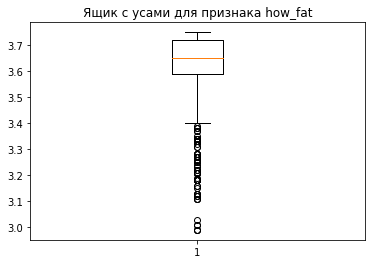

In [39]:
plt.boxplot(ferma_main['how_fat'])
plt.title('Ящик с усами для признака how_fat')

Text(0.5, 0, 'Жирность,%')

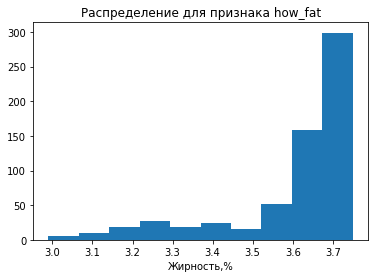

In [40]:
plt.hist(ferma_main['how_fat'], bins=10) 
plt.title('Распределение для признака how_fat')
plt.xlabel('Жирность,%')

Видим большок количество выбросов, заменить их другим значением мы не можем, это исказит данные, посмотрим сколько их всего, чтобы понять, можно ли их удалить. 

In [41]:
ferma_main[ferma_main['how_fat']<(3.59-1.5*(3.72-3.59))]['how_fat'].count()/len(ferma_main['how_fat'])

0.13694267515923567

выбросы состовляют около 13,6% от всех значений признака, удаление такого объема негативно скажется в дальнейшем, оставим как есть. 

<b>belok (Белок,%)</b>

Text(0.5, 1.0, 'Ящик с усами для признака belok')

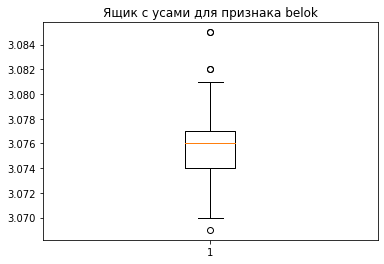

In [42]:
plt.boxplot(ferma_main['belok'])
plt.title('Ящик с усами для признака belok')

Text(0.5, 0, 'содержание белка в молоке')

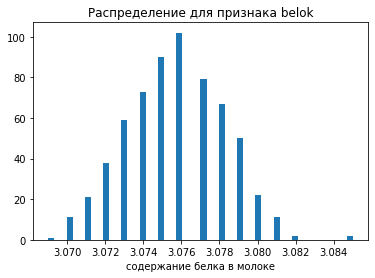

In [43]:
plt.hist(ferma_main['belok'], bins=50) 
plt.title('Распределение для признака belok')
plt.xlabel('содержание белка в молоке')

Распределение нормальное, есть 3 выброса, удалим их. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7feca42caf40>,
 'caps': [<matplotlib.lines.Line2D at 0x7feca42a3640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feca42cabe0>],
 'medians': [<matplotlib.lines.Line2D at 0x7feca42a3d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feca42a60a0>],
 'means': []}

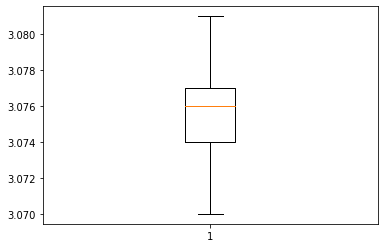

In [44]:
ferma_main = ferma_main.query('3.074-1.5*(3.077-3.074) < belok < 3.077+1.5*(3.077-3.074)')
plt.boxplot(ferma_main['belok'])

Мы проанализировали численные признаки, обработали аномалии в них, теперь можем приступить к категориальным. 

<b>race (Порода)</b>

<AxesSubplot:title={'center':'соотношение пород'}, ylabel='race'>

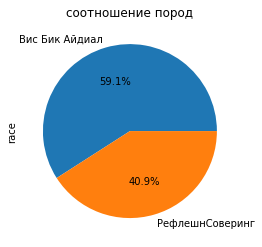

In [45]:
ferma_main['race'].value_counts().plot(kind='pie', title='соотношение пород', autopct='%1.1f%%')

Порода Вис Бик Айдал встречается чаще, но разница небольшая, данные о породе почти делятся пополам. 

<b>pastbish_type (тип пастбища)</b>


<AxesSubplot:title={'center':'соотношение типов пастбищ'}, ylabel='pastbish_type'>

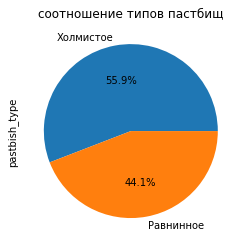

In [46]:
ferma_main['pastbish_type'].value_counts().plot(kind='pie', title='соотношение типов пастбищ', autopct='%1.1f%%')

Как и с соотношением пород, разница небольшая, но холмистые пастбища встречаются чаще. 

<b>race_papa_byk (порода папы_быка)</b>


<AxesSubplot:title={'center':'соотношение пород папы быка'}, ylabel='race_papa_byk'>

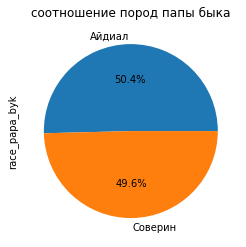

In [47]:
ferma_main['race_papa_byk'].value_counts().plot(kind='pie', title='соотношение пород папы быка', autopct='%1.1f%%')

В этом случае данные еще ближе к соотношению 1:1. 

<b>milk_taste (вкус молока)</b>


<AxesSubplot:title={'center':'вкус молока'}, ylabel='milk_taste'>

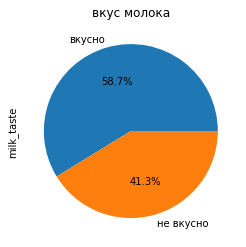

In [48]:
ferma_main['milk_taste'].value_counts().plot(kind='pie', title='вкус молока', autopct='%1.1f%%')

Чаще молоко оказывается вкусным. 

<b>age (возраст коровы)</b>


<AxesSubplot:title={'center':'возраст'}, ylabel='age'>

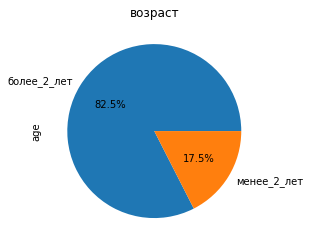

In [49]:
ferma_main['age'].value_counts().plot(kind='pie', title='возраст', autopct='%1.1f%%')

Коров, которым более 2 лет намного больше, чем тех, кому меньше, это связано с выбранной границей, диапазон возможных возрастов для условия больше двух лет намного больше. Это не аномалия. 

Мы провели исследовательский анализ данных и рассмотрели отдельно числове и категориальные признаки. Аномалии обнаружились в значениях удоя, жирности и процента белка. В случае жирности мы не исправляли это, поскольку выбросов слишком много, что исказило бы данные, в других двух удалили выбросы. В категориальных признаках не обнаружено аномалий, все значения, кроме возраста, близки к соотношению 1:1. 

## Корреляционный анализ

Посмотрим, как коррелируют между собой значения таблицы ferma_main, для этого построим матрицу корреляции и диаграммы рассеяния.

interval columns not set, guessing: ['udoi', 'eke', 'raw_protein', 'spo', 'how_fat', 'belok']


<AxesSubplot:>

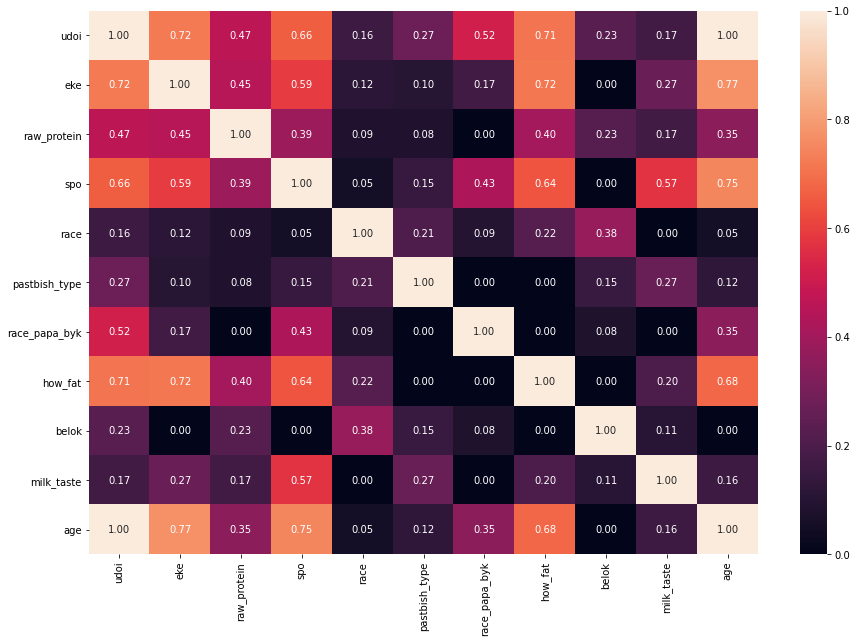

In [50]:
data_corr = ferma_main.drop('id', axis=1)
plt.figure(figsize=(15, 10))
sns.heatmap(data_corr.phik_matrix(), annot=True, fmt='.2f') 

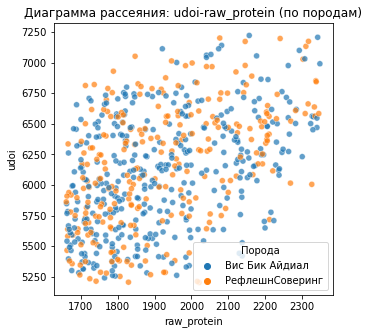

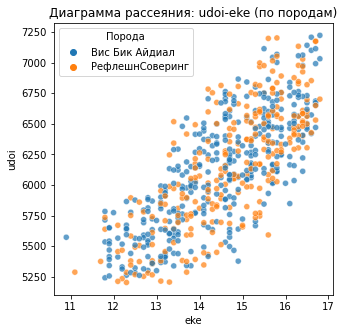

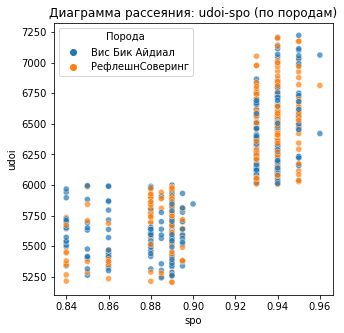

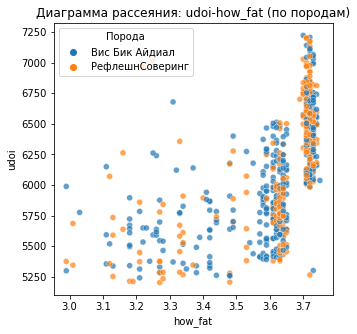

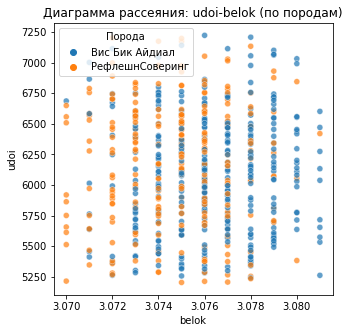

In [51]:
df = ['raw_protein', 'eke', 'spo', 'how_fat', 'belok']
for i in df:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=ferma_main, x=i, y='udoi', hue='race', alpha=0.7)
    plt.title(f'Диаграмма рассеяния: udoi-{i} (по породам)')
    plt.xlabel(i)
    plt.ylabel('udoi')
    plt.legend(title='Порода')

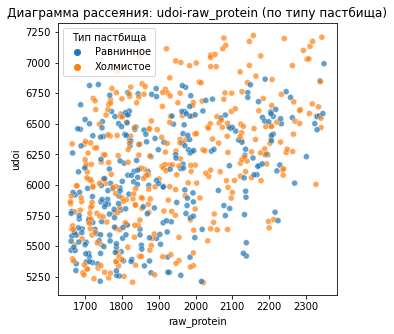

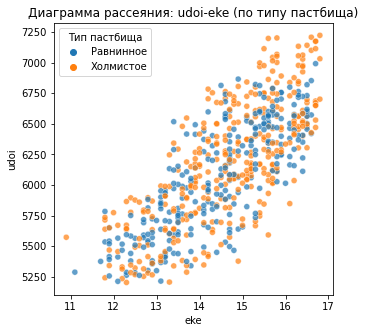

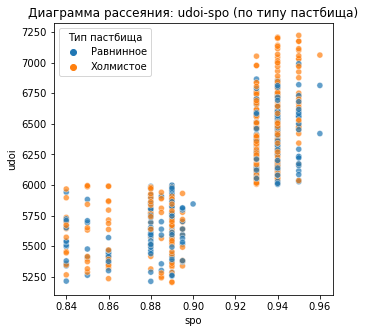

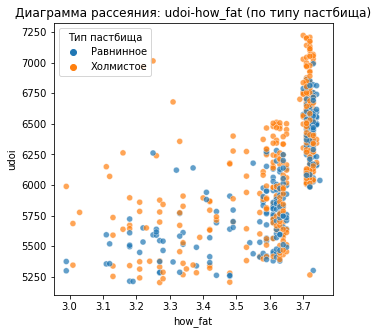

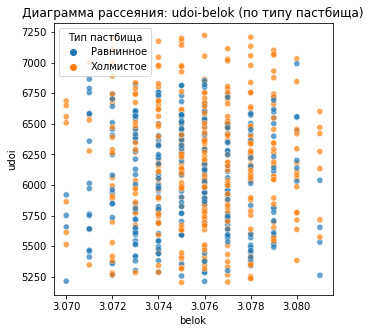

In [52]:
df = ['raw_protein', 'eke', 'spo', 'how_fat', 'belok']
for i in df:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=ferma_main, x=i, y='udoi', hue='pastbish_type', alpha=0.7)
    plt.title(f'Диаграмма рассеяния: udoi-{i} (по типу пастбища)')
    plt.xlabel(i)
    plt.ylabel('udoi')
    plt.legend(title='Тип пастбища')

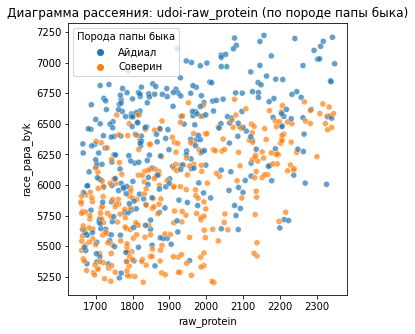

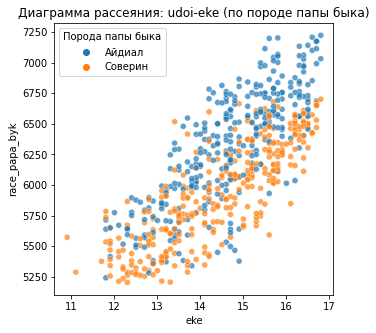

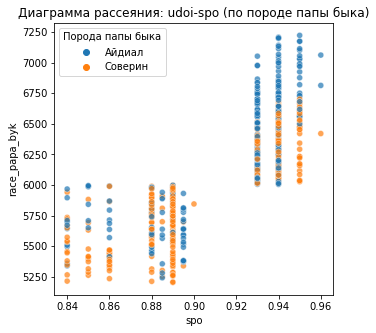

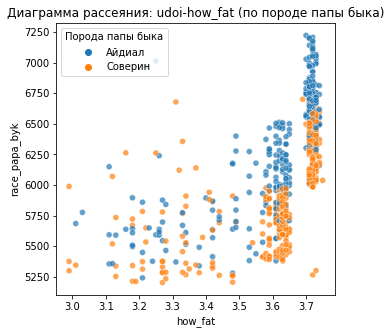

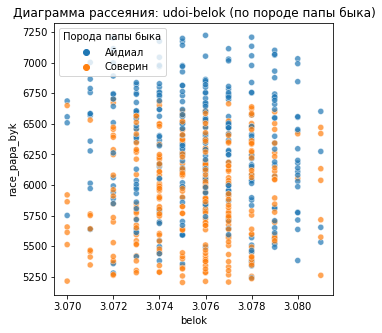

In [53]:
df = ['raw_protein', 'eke', 'spo', 'how_fat', 'belok']
for i in df:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=ferma_main, x=i, y='udoi', hue='race_papa_byk', alpha=0.7)
    plt.title(f'Диаграмма рассеяния: udoi-{i} (по породе папы быка)')
    plt.xlabel(i)
    plt.ylabel('race_papa_byk')
    plt.legend(title='Порода папы быка')

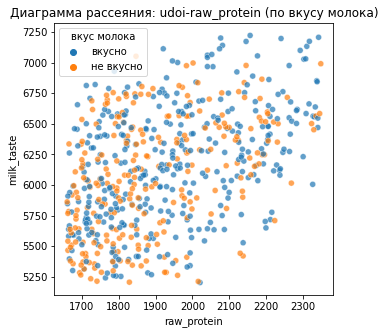

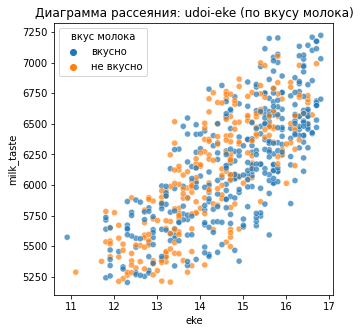

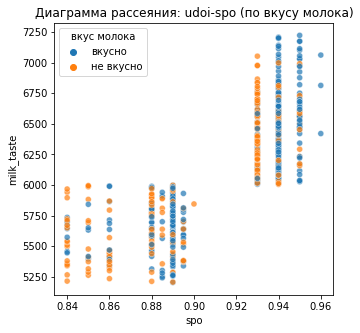

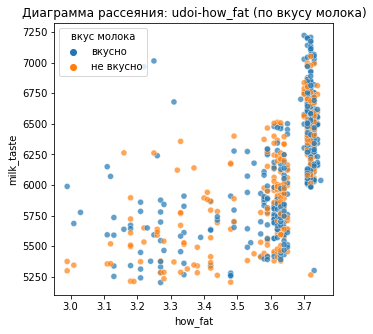

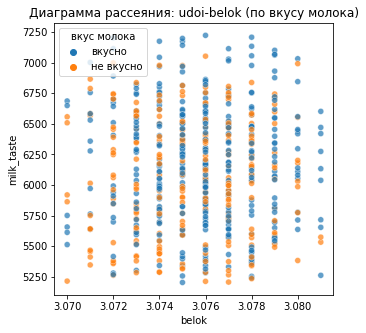

In [54]:
df = ['raw_protein', 'eke', 'spo', 'how_fat', 'belok']
for i in df:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=ferma_main, x=i, y='udoi', hue='milk_taste', alpha=0.7)
    plt.title(f'Диаграмма рассеяния: udoi-{i} (по вкусу молока)')
    plt.xlabel(i)
    plt.ylabel('milk_taste')
    plt.legend(title='вкус молока')

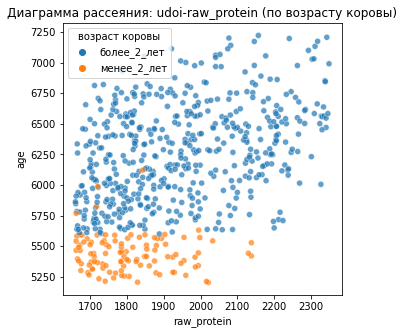

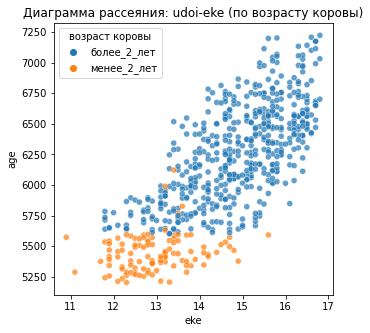

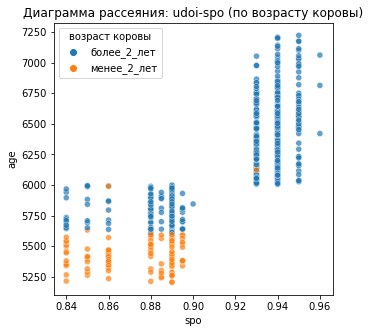

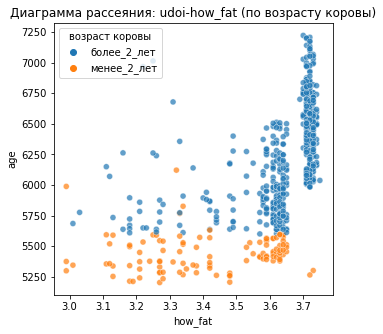

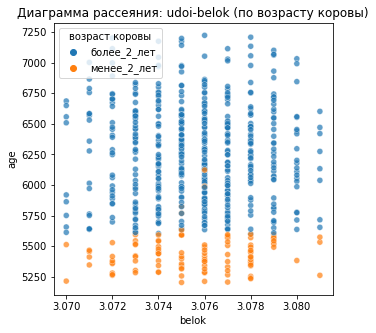

In [55]:
df = ['raw_protein', 'eke', 'spo', 'how_fat', 'belok']
for i in df:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=ferma_main, x=i, y='udoi', hue='age', alpha=0.7)
    plt.title(f'Диаграмма рассеяния: udoi-{i} (по возрасту коровы)')
    plt.xlabel(i)
    plt.ylabel('age')
    plt.legend(title='возраст коровы')

Мы узнали коэфициенты корреляции между признаками и посторили диаграммы рассеяния для признака удой и всех количественных признаков в с учётом значения категориальных. 
Самая высокая корреляция со значением удой наблюдается у признаков Эке, СПО, процент жирности, коээфициенты равны 0,72; 0,66; 0,71 соответственно. Довольно высокое значение, но и мультиколлинеарность отсутсвует, оставим эти признаки. Однако, у Эке и процента жирности линейная связь с признаком удой, а у признака СПО диаграмма рассеяния выглядит довольно подозрительно, связь похожа на нелинейную, но с переходом между СПО 0,90 и 0,93. Категориальные признаки, не считая возраста сильно на них не влияют. 
Между содержанием белка и признаком удой нелинейная связь с корреляцией 0,23. Также на значение белка влияет порода папы быка, как видно на диаграмме рассеяния, у коров, чей отец Айдиал дают молоко с большим уровнем белка. 
Связь между значением сырого протеина и удоем ближе к линейной, но разброс значений довольно большой, их коэфициент корреляции 0,47. 
Самый высокий коэфициент корреляции с признаком удой наблюдается у возраста коровы, он составляет 1, это подтверждают и диаграммы рассеяния.  

Таким образом, признаков с линейной зависимостью относительно удоя больше, чем с нелинейной. Больше всего на удой влияют возраст коровы, Эке и процент жирности. Нелинейные связи присутсвут, но не требуют добавления новых признаков. Мультиколлениарности не обнаружено.  

## Обучение модели линейной регрессии

<b>Модель №1</b>

Сначала уберем признаки, котрые не подходят для модели линейной регрессии:
- убираем id, это уникальное значение, не влияющее на удой
- процент жирности и белка, вкус молока являются характеристикой самого молока, значит не влияют на удой коровы и их можно убрать

После этого можем обучать модель. 

In [56]:
ferma_main_1 = ferma_main.drop(['id', 'how_fat', 'belok', 'milk_taste'], axis=1)
num_col = ['raw_protein', 'eke', 'spo']
categoric_col = ['race', 'pastbish_type', 'age', 'race_papa_byk']

RANDOM_STATE = 42

X = ferma_main_1.drop('udoi', axis=1)
y = ferma_main_1['udoi']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

encoder  = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train_1[categoric_col])
X_test_ohe = encoder.transform(X_test_1[categoric_col])
encoder_col_names = encoder.get_feature_names(categoric_col)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_1[num_col])
X_test_scaled = scaler.transform(X_test_1[num_col])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

X_train_1 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_1 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr  = LinearRegression()
model_lr.fit(X_train_1, y_train_1)
predictions_1 = model_lr.predict(X_test_1)


r2_1 = r2_score(y_test_1, predictions_1)
"R2 LinearRegression =", r2_1

('R2 LinearRegression =', 0.7832029531509054)

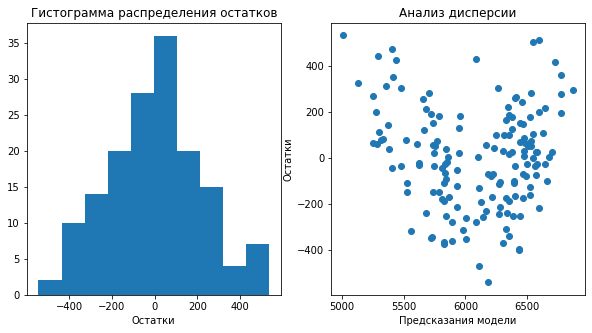

In [57]:
residuals_1 = y_test_1-predictions_1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals_1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_1, y=residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Коэффициент детерминации R² близок к 1, значит модель работает качественно, в 78% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. 
Остатки распределены нормально, график симметричен относительно 0, значит в среднем остаток равен 0, а при других отаках модель дает как завышенные, так и заниженные ожидания. 
Около показаний модели в 6000 остатки разбросаны иначе, в основном в отрицательную сторону, для улучшения качества модели можно исследовать эти значения подробнее. 

<b>Модель №2</b>

In [58]:
ferma_main_2 = ferma_main.drop(['id', 'how_fat', 'belok', 'milk_taste'], axis=1)
num_col = ['raw_protein', 'eke', 'spo']
categoric_col = ['race', 'pastbish_type', 'age', 'race_papa_byk']

ferma_main_2['eke'] = ferma_main_2['eke']**2
ferma_main_2['spo'] = ferma_main_2['spo'].apply(lambda spo: 0 if spo < 0.91 else 1)
ferma_main_2.head()

,udoi,eke,raw_protein,spo,race,pastbish_type,race_papa_byk,age
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,более_2_лет
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет


In [59]:
RANDOM_STATE = 42

X = ferma_main_2.drop('udoi', axis=1)
y = ferma_main_2['udoi']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

encoder  = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train_2[categoric_col])
X_test_ohe = encoder.transform(X_test_2[categoric_col])
encoder_col_names = encoder.get_feature_names(categoric_col)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2[num_col])
X_test_scaled = scaler.transform(X_test_2[num_col])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

X_train_2 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_2 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr  = LinearRegression()
model_lr.fit(X_train_2, y_train_2)
predictions_2 = model_lr.predict(X_test_2)

r2_2 = r2_score(y_test_2, predictions_2)
"R2 LinearRegression =", r2_2

('R2 LinearRegression =', 0.8347436421181885)

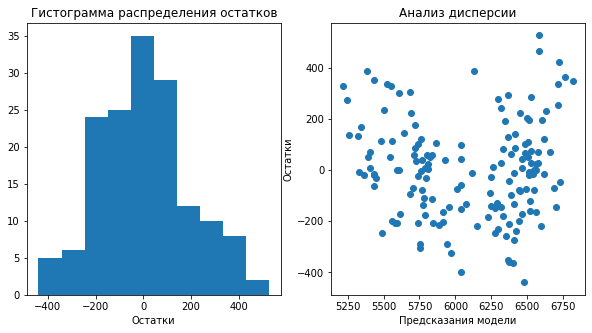

In [60]:
residuals_2 = y_test_2-predictions_2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals_2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_2, y=residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма распределения остатков симметрична относительно 0, а распределение близко к нормальному, как и диспрерсия остатоков, это говорит о хорошем качестве модели. Значение R2 выросло, значит предсказания модели стали еще ближе к истине. 

<b>Модель №3</b>

In [61]:
ferma_main_3 = ferma_main.merge(ferma_dad, on='id')
ferma_main_3 = ferma_main_3.drop(['id', 'how_fat', 'belok', 'milk_taste'], axis=1)
num_col = ['raw_protein', 'eke', 'spo']
categoric_col = ['race', 'pastbish_type', 'age', 'race_papa_byk', 'papa_name']
ferma_main_3['pastbish_type'] = ferma_main_3['pastbish_type'].str.lower()

ferma_main_3['eke'] = ferma_main_3['eke']**2
ferma_main_3['spo'] = ferma_main_3['spo'].apply(lambda spo: 0 if spo < 0.91 else 1)
ferma_main_3.head()


,udoi,eke,raw_protein,spo,race,pastbish_type,race_papa_byk,age,papa_name
0,5863,201.64,1743,0,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,холмистое,Соверин,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Барин


In [62]:
RANDOM_STATE = 42

X = ferma_main_3.drop('udoi', axis=1)
y = ferma_main_3['udoi']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

encoder_3  = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_3.fit_transform(X_train_3[categoric_col])
X_test_ohe = encoder_3.transform(X_test_3[categoric_col])
encoder_col_names = encoder_3.get_feature_names(categoric_col)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


scaler_3 = StandardScaler()
X_train_scaled = scaler_3.fit_transform(X_train_3[num_col])
X_test_scaled = scaler_3.transform(X_test_3[num_col])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

X_train_3 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_3 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr_3  = LinearRegression()
model_lr_3.fit(X_train_3, y_train_3)
predictions_3 = model_lr_3.predict(X_test_3)

r2_3 = r2_score(y_test_3, predictions_3)
"R2 LinearRegression =", r2_3

('R2 LinearRegression =', 0.841398663566452)

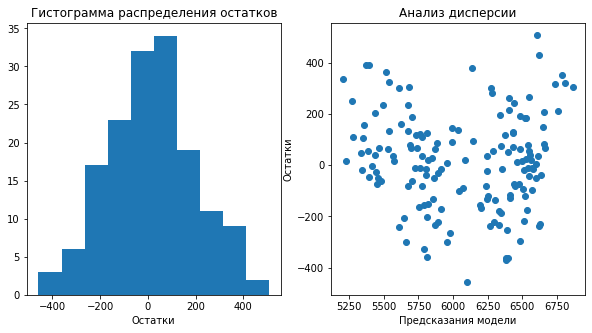

In [63]:
residuals_3 = y_test_3-predictions_3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals_3)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_3, y=residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Добавление нового признака положительно повлияло на оценку R2, теперь коэффициент детерминации равен 0,84. График распределения остатков стал еще более симметричным относительно нуля. 

Сравним три модели и выберем лучшую. 

In [64]:
print(r2_1)
print(r2_2)
print(r2_3)

0.7832029531509054
0.8347436421181885
0.841398663566452


In [65]:
print(residuals_1.mean())
print(residuals_2.mean())
print(residuals_3.mean())

1.6617550037305755
3.7396400790567976
16.983546889152933


Самый высокий показать R2 у третьей модели, он равен 0.84139866, но наименьшее среднее значение остатков показывает модель №1. Оценим модели по дополнительным метрикам MSE, MAE, RMSE

In [66]:
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    return mse, mae, rmse

mse_1, mae_1, rmse_1 = metrics(y_test_1, predictions_1)
mse_2, mae_2, rmse_2 = metrics(y_test_2, predictions_2)
mse_3, mae_3, rmse_3 = metrics(y_test_3, predictions_3)


print(f"Модель 1: MSE = {mse_1:.2f}, MAE = {mae_1:.2f}, RMSE = {rmse_1:.2f}")
print(f"Модель 2: MSE = {mse_2:.2f}, MAE = {mae_2:.2f}, RMSE = {rmse_2:.2f}")
print(f"Модель 3: MSE = {mse_3:.2f}, MAE = {mae_3:.2f}, RMSE = {rmse_3:.2f}")

Модель 1: MSE = 47500.00, MAE = 173.80, RMSE = 217.94
Модель 2: MSE = 36207.49, MAE = 149.72, RMSE = 190.28
Модель 3: MSE = 34749.38, MAE = 146.72, RMSE = 186.41


Лучшей моделью, согласно метрикам, является модель №3, у нее самое высокое значение R2 и MSE, MAE, RMSE ниже, чем у первых двух. 
Рассчитаем для нее 95% доверительный интервал. Для этого возьмем 2.5-й и 97.5-й квантили ошибок. 

In [67]:
y_train_pred_3 = model_lr_3.predict(X_train_3)
train_errors_3 = y_train_3 - y_train_pred_3
low_quant = np.percentile(train_errors_3, 2.5)
up_quant = np.percentile(train_errors_3, 97.5)
low_quant, up_quant

(-359.2813504924277, 374.08769262772387)

Доверительный интервал для финальной модели: (-359.28135, 374.08769), с 95% вероятностью ошибка прогноза для новых данных будет находиться в этом диапазоне. 

In [68]:
cow_buy['eke'] = ferma_main['eke'].mean()*1.05
cow_buy['raw_protein'] = ferma_main['raw_protein'].mean()*1.05
cow_buy['spo'] = ferma_main['spo'].mean()*1.05
cow_buy.head()

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age,eke,raw_protein,spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276742,2019.77191,0.958947
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276742,2019.77191,0.958947
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276742,2019.77191,0.958947


In [69]:
cow_buy_1 = cow_buy.drop(['how_fat_now', 'belok_now',], axis=1)
num_col = ['raw_protein', 'eke', 'spo']
categoric_col = ['race', 'pastbish_type', 'age', 'race_papa_byk', 'papa_name']

cow_buy_1['eke'] = cow_buy_1['eke']**2
cow_buy_1['spo'] = cow_buy_1['spo'].apply(lambda spo: 0 if spo < 0.91 else 1)
cow_buy_1.head()

,race,pastbish_type,race_papa_byk,papa_name,age,eke,raw_protein,spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,более_2_лет,233.378833,2019.77191,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,менее_2_лет,233.378833,2019.77191,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,более_2_лет,233.378833,2019.77191,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,более_2_лет,233.378833,2019.77191,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,более_2_лет,233.378833,2019.77191,1


In [70]:
X_buy_ohe = encoder_3.transform(cow_buy_1[categoric_col])
encoder_col_names = encoder_3.get_feature_names(categoric_col)
X_buy_ohe = pd.DataFrame(X_buy_ohe, columns=encoder_col_names)


X_buy_scaled = scaler_3.transform(cow_buy_1[num_col])
X_buy_scaled = pd.DataFrame(X_buy_scaled, columns=num_col)

X_buy_prepared = pd.concat([X_buy_ohe, X_buy_scaled], axis=1)

predictions = model_lr_3.predict(X_buy_prepared)
predictions

array([6609.25367288, 6358.10267231, 6283.59321351, 6599.11444126,
       6544.61992539, 6442.50025097, 6609.25367288, 6556.59715012,
       6283.59321351, 6400.61996346, 6334.07609338, 6640.99472878,
       6609.25367288, 6102.46407806, 6283.59321351, 6599.11444126,
       6334.07609338, 6442.50025097, 6556.59715012, 6544.61992539])

In [71]:
cow_buy['udoi_predict'] = predictions
cow_buy

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age,eke,raw_protein,spo,udoi_predict
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276742,2019.77191,0.958947,6358.102672
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,6283.593214
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276742,2019.77191,0.958947,6599.114441
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276742,2019.77191,0.958947,6544.619925
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276742,2019.77191,0.958947,6442.500251
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276742,2019.77191,0.958947,6556.597150
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,6283.593214
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276742,2019.77191,0.958947,6400.619963


Мы обучили 3 модели и выбрали лучшую из них под номеров 3. Ее метрики:
MSE = 34749.38, MAE = 146.72, RMSE = 186.41, R2 = 0.84139866. 
Итак, мы построили прогноз для удоя коров с помощью лучшей модели. Согласно предсказаниям, все коровы дадут больше 6000 кг молока, а значит всех можно порекомендовать фермеру, но стоит учесть и вкус молока. 

## Обучение модели логистической регрессии

In [72]:
ferma_main_log = ferma_main.merge(ferma_dad, on='id')
ferma_main_log = ferma_main_log.drop(['id', 'how_fat', 'belok'], axis=1)
num_col = ['raw_protein', 'eke', 'spo']
categoric_col = ['race', 'pastbish_type', 'age', 'race_papa_byk', 'papa_name']
ferma_main_log['pastbish_type'] = ferma_main_log['pastbish_type'].str.lower()

ferma_main_log['eke'] = ferma_main_log['eke']**2
ferma_main_log['spo'] = ferma_main_log['spo'].apply(lambda spo: 0 if spo < 0.91 else 1)
ferma_main_log['milk_taste'] = ferma_main_log['milk_taste'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_main_log.head()


,udoi,eke,raw_protein,spo,race,pastbish_type,race_papa_byk,milk_taste,age,papa_name
0,5863,201.64,1743,0,Вис Бик Айдиал,равнинное,Айдиал,1,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,равнинное,Соверин,1,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,холмистое,Соверин,0,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,холмистое,Айдиал,0,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,равнинное,Соверин,1,менее_2_лет,Барин


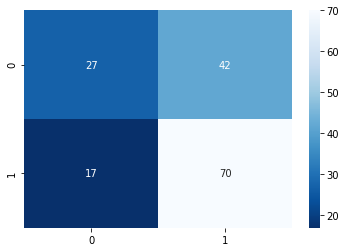

In [73]:
RANDOM_STATE = 42

X = ferma_main_log.drop('milk_taste', axis=1)
y = ferma_main_log['milk_taste']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

encoder_log  = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_log.fit_transform(X_train_log[categoric_col])
X_test_ohe = encoder_log.transform(X_test_log[categoric_col])
encoder_col_names = encoder_log.get_feature_names(categoric_col)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


scaler_log = StandardScaler()
X_train_scaled = scaler_log.fit_transform(X_train_log[num_col])
X_test_scaled = scaler_log.transform(X_test_log[num_col])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

X_train_log = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_log = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train_log, y_train_log)

y_pred_log = clf.predict(X_test_log)

recall = recall_score(y_test_log, y_pred_log)
precision = precision_score(y_test_log, y_pred_log)
acc = accuracy_score(y_test_log, y_pred_log)
cm = confusion_matrix(y_test_log, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

In [74]:
print('accuracy:', acc)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.6217948717948718
precision: 0.625
recall: 0.8045977011494253


Модель довстаточно часто выдает ложноположительные ответы, presision и accuracy близки к половине, хотя recall выше(0,8)
Так как фермеру важен вкус молока, нам нужно исключить ошибки первого рода, вкусное молоко, предсказанное как невкусное не так критично как наоборот. Сейчас таких ошибок 42. Нас интересует метрика presicion, его надо привести к максимуму, выберем для этого порог классификации. 

In [83]:
y_proba = clf.predict_proba(X_test_log)[:, 1]

data = pd.DataFrame(zip(y_test_log, y_proba),
                    columns=['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)

thresholds = [0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8]
columns = []

for i in thresholds:
    columns.append('y_pred_' + str(i))
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda y_proba: 0 if y_proba < i else 1)

print(data.sample(5))

     y_valid   y_proba  y_pred_0.65  y_pred_0.66  y_pred_0.67  y_pred_0.68  \
92         0  0.590928            0            0            0            0   
86         0  0.423137            0            0            0            0   
105        1  0.675407            1            1            1            0   
47         1  0.432843            0            0            0            0   
13         1  0.402275            0            0            0            0   

     y_pred_0.69  y_pred_0.7  y_pred_0.71  y_pred_0.72  y_pred_0.73  \
92             0           0            0            0            0   
86             0           0            0            0            0   
105            0           0            0            0            0   
47             0           0            0            0            0   
13             0           0            0            0            0   

     y_pred_0.74  y_pred_0.75  y_pred_0.76  y_pred_0.77  y_pred_0.78  \
92             0            0   

In [84]:
precision_results = []
for i in thresholds:
    data['pred'] = data['y_proba'].apply(lambda y_proba: 0 if y_proba < i else 1)
    precision = precision_score(data['y_valid'], data['pred'])
    precision_results.append({'Threshold': i, 'Precision': precision})

precision_df = pd.DataFrame(precision_results)
precision_df

,Threshold,Precision
0,0.65,0.696429
1,0.66,0.705882
2,0.67,0.717391
3,0.68,0.720930
4,0.69,0.725000
5,0.70,0.725000
6,0.71,0.743590
7,0.72,0.823529
8,0.73,0.903226
9,0.74,0.925926


Ошибки первого рода исчезают на промежутке с порогом от 0,78 до 0,79. Рассмотрим его более детально, чтобы выбрать минимальный, так будет меньше ошибок второго рода. 

In [85]:
thresholds = [round(i, 4) for i in np.arange(0.78, 0.791, 0.0005)]
precision_results = []
for i in thresholds:
    data['pred'] = data['y_proba'].apply(lambda y_proba: 0 if y_proba < i else 1)
    precision = precision_score(data['y_valid'], data['pred'])
    precision_results.append({'Threshold': i, 'Precision': precision})

precision_df = pd.DataFrame(precision_results)
precision_df

,Threshold,Precision
0,0.7800,0.95
1,0.7805,0.95
2,0.7810,0.95
3,0.7815,0.95
4,0.7820,0.95
5,0.7825,0.95
6,0.7830,0.95
7,0.7835,0.95
8,0.7840,0.95
9,0.7845,0.95


Так, для сведения ошибки первого рода к нулю, нам необходим порог принадлежности, равный 0.785  

In [86]:
y_proba = clf.predict_proba(X_test_log)[:, 1]

data = pd.DataFrame(zip(y_test_log, y_proba),
                    columns=['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)

threshold = 0.785

data['y_pred'] = data['y_proba'].apply(lambda y_proba: 0 if y_proba < threshold else 1)

recall = recall_score(data['y_valid'], data['y_pred'])
precision = precision_score(data['y_valid'], data['y_pred'])
print(recall)
print(precision)

0.21839080459770116
1.0


Выбран порог 0.785. Значение recall сильно упало, теперь оно равно 0.218, однако мы достигли своей цели и избавились от всех ошибок первого рода, теперь precision=1. 
Дальше мы моджем приступать к прогнозу вкуса молока, использовав найденый порог. 

In [87]:
cow_buy_2 = cow_buy.drop(['how_fat_now', 'belok_now',], axis=1)
num_col = ['raw_protein', 'eke', 'spo']
categoric_col = ['race', 'pastbish_type', 'age', 'race_papa_byk', 'papa_name']

cow_buy_2['eke'] = cow_buy_2['eke']**2
cow_buy_2['spo'] = cow_buy_2['spo'].apply(lambda spo: 0 if spo < 0.91 else 1)
cow_buy_2.head()

,race,pastbish_type,race_papa_byk,papa_name,age,eke,raw_protein,spo,udoi_predict,milk_taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,более_2_лет,233.378833,2019.77191,1,6609.253673,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,менее_2_лет,233.378833,2019.77191,1,6358.102672,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,более_2_лет,233.378833,2019.77191,1,6283.593214,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,более_2_лет,233.378833,2019.77191,1,6599.114441,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,более_2_лет,233.378833,2019.77191,1,6544.619925,не вкусно


In [88]:
cow_buy_ohe = encoder_log.transform(cow_buy_2[categoric_col])
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)

cow_buy_scaled = scaler_log.transform(cow_buy_2[num_col])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col)

cow_buy_2 = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

y_proba = clf.predict_proba(cow_buy_2)[:, 1]

cow_buy['milk_taste'] = y_proba > threshold
cow_buy['milk_taste'] = cow_buy['milk_taste'].apply(lambda x: 'вкусно' if x == True else 'не вкусно')  
cow_buy

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age,eke,raw_protein,spo,udoi_predict,milk_taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276742,2019.77191,0.958947,6358.102672,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,6283.593214,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276742,2019.77191,0.958947,6599.114441,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276742,2019.77191,0.958947,6544.619925,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276742,2019.77191,0.958947,6442.500251,не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276742,2019.77191,0.958947,6556.597150,не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,6283.593214,не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276742,2019.77191,0.958947,6400.619963,не вкусно


С таким высоким порогом принадлежности к классам все молоко определяется как невкусное, немного понизим его, возьмем пороговое значение 0,69, согласно предыдущему анализу влияния порога на метрику percision, она будет равняться 0,725, это довольно высокое значение. Так, мы минимизируем ошибки первого рода, но сможем определить вкусное молоко среди тех коров, которых хочет купить фермер. 

In [89]:
threshold = 0.69
cow_buy['milk_taste'] = y_proba > threshold
cow_buy['milk_taste'] = cow_buy['milk_taste'].apply(lambda x: 'вкусно' if x == True else 'не вкусно')  
cow_buy

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age,eke,raw_protein,spo,udoi_predict,milk_taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276742,2019.77191,0.958947,6358.102672,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,6283.593214,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276742,2019.77191,0.958947,6599.114441,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276742,2019.77191,0.958947,6544.619925,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276742,2019.77191,0.958947,6442.500251,не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276742,2019.77191,0.958947,6556.597150,не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,6283.593214,не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276742,2019.77191,0.958947,6400.619963,не вкусно


Итак, мы обучили модель логистической регрессии, и подобрали порог, при котором минимизируются ошибки первого рода, поскольку нам нельзя допустить, чтобы молоко оказалось ложно вкусно предсказанным.  
Согласно предсказанию, среди всех коров, которых рассматривает для покупки фермер вкусное молоко дают три из них. 

## Итоговые выводы

In [90]:
cow_buy.query('milk_taste=="вкусно"&udoi_predict>6000')

,race,pastbish_type,race_papa_byk,papa_name,how_fat_now,belok_now,age,eke,raw_protein,spo,udoi_predict,milk_taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,вкусно
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,15.276742,2019.77191,0.958947,6609.253673,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276742,2019.77191,0.958947,6102.464078,вкусно


- Из таблицы cow_buy отобраны коровы, которые с высокой вероятностью будут давать более 6000 кг молока в год и вкусное молоко. Таких среди них оказалось четыре, именнно их фермер он может купить из стада на продажу с минимальным риском для себя. 

- Фермеру стоит также рассмотреть коров с максимальным предсказанным удоем, поскольку вкус молока - это субъективная оценка и его количество может быть более важным фактором. Для улучшения качества прогноза фермеру стоит указывать более точный возраст коровы, порог в 2 года может быть не самым информативным, точный возраст подошел бы лучше. 

- Для прогноза удоя и вкуса молока были обучены модели линейной и логистической регрессии. Для повышения точности их работы мы избавились от нелинейности и признаков, не влияющих на целевой. В модели логистической регрессии мы минимизировали ошибки первого рода с помощью определения порога вхождения, чтобы предсказанное вкусное молоко действительно оказалось таким. 

- При анализе рисков или экономических расчётах важны мтерики качества работы модели, которые мы также использовали в своей работе. 
    - R2: помогает оценить надёжность прогнозов удоя, в нашей финальной модели линейной регрессии R2=0.84
    - MSE: средний квадрат ошибки модели, чувствительна к выбросам, в финальной модели равна 34749.38
    - RMSE: показывает среднюю ошибку в кг, что важно для оценки риска. в нашей финальной модели линейной регрессии RMSE=186.41
    - MAE: даёт более устойчивое представление об ошибке, поскольку устойчива к выбросам, в нашей модели равна 146.72
    - accuracy: показывает сколько правильных ответов дала модель, относительно всех на тестовой выборке
    - precision: показывает точность, с которой модель присваивает объектам класс 1, именно эту метрику мы увеличивали, чтобы минимизировать ошибки первого рода
    - recall: измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса, ей мы пренебрегли, поскольку было важнее максимально точно выбрать только вкусное молоко 

- Для улучшения точности регрессионной модели стоит учитывать больше признаков самой коровы, а также не только отца, но и мать. Также стоит учитывать конкретнв
 